
### Background 

Traditional newspaper still play an important role in shaping the public perception on different topics which makes it essential to understand the framing within these institutions.  This work focuses on the depiction of refugees in traditional news media which has especially since the so-called “refugee crisis” experienced a broad coverage in scientific sphere. 
Backfried and Shalunts (2016) for example conduct a comparative sentiment analysis on the most circulating traditional media in Germany, Austria and Switzerland as well as the social media platform Facebook and Twitter. The authors make use of lexicon based approach to sentiment analysis. Thereby words are associated with certain sentiment scores and the overall sentiment of a text is calculated based on the words that it includes. These models are rule-based and contrary to deep neural networks (as for example BERT) do not require training. Other works focus more on the discussed topics. Moore et al. (2018) show the strong deviations regarding the discussed topics related with the “refugee crisis” in different European newspapers. 

### Data 

In [73]:
# Loading packages 
import pandas as pd
import numpy as np
import requests

In [ ]:
# Loading the data
url = "https://raw.githubusercontent.com/linuscov/CCA-/main/articles.csv"
articles_df = pd.read_csv(url)

The source of data are articles on the topic of refugees from the German national weekly newspaper “Die Zeit” which has a liberal political alignment. Using a web-scraping algorithm I collected the most recent 5000 articles that were shown on the newspaper’s website under the keyword “Flüchtling” (refugee). This resulted in a covered time span from May 2018 to December 2022.


### Sentiment Analysis with BERT

BERT models generally show a better performance than lexicon-based approaches (Kotelnikova et al. 2022). Moreover in contrast to older models like VADER which take a bag of words (BOW) approach to sentiment analysis, BERT also consideres the context of word by looking at its relationship to other terms (Kedia & Rasu 2020), which is very important for human speech.  Due to the broad supply of pretrained models they are very easy to incorporate. While German does still not reach the same accuracy as English it does overcome the limitations that especially smaller languages face regarding train-intensive models. BERT models have a limitation to 512 tokens which makes them not directly applicable to longer text. While one can technically separate into several 512 tokens sequences and then take the average in the end I chose the more simple method of truncating everything after the 512th token. I used the bert-base-multilingual-uncased-sentiment model for tokenization and classification. The output is a 1 to 5 rating with 1 indicating very negative and 5 indicating very positive. The reported accuracy is 61% for exact accuracy and 94% for Accuracy of by 1. 


In [6]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [5]:
# Import Packages 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# Downloading the pretrained Tokenizer and Classification Model 
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [5]:
# Writing a function to determine the sentiment score of a document 
def sentiment_scores(article):
    tokens = tokenizer.encode(article, return_tensors = 'pt', truncation = True)
    result = model(tokens) # this gives 5 values showing the likelihood of the input having a certain sentiment score 
    result = int(result)
    return int(torch.argmax(result.logits))+1 # returns only the sentiment score with the highest likelihood  

In [89]:
# Calculating the sentiment scores for all documents 
scores = articles_df['Text'].apply(lambda x: sentiment_scores(x[:512])) # restricted to the first 512 tokens 
articles_df['Scores'] = scores


In [7]:
# this takes a while to run, alternatively the articles_df with the sentiment scores can be downloaded from here 

url = "https://raw.githubusercontent.com/linuscov/CCA-/main/articles.scores.csv"
articles_df = pd.read_csv(url)

### Visualization of sentiment analysis


In [2]:
# install and import visualization package 
# conda install -f matplotlib
import matplotlib.pyplot as plt

In [8]:
scores_count = list(articles_df['Scores'].value_counts())
scores_count = [scores_count[index] for index in [0,2,3,1,4]] # bringing the list in a contiuous order from 1 to 5

Text(0.5, 1.0, 'Sentiment shares')

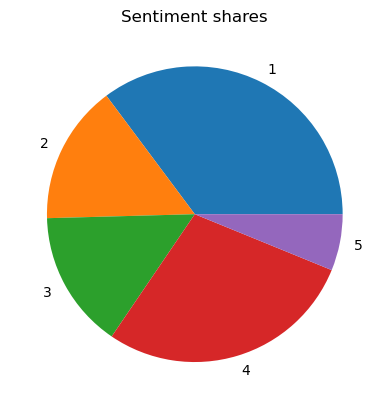

In [9]:
score_val = [1,2,3,4,5]
plt.pie(scores_count, labels = score_val)
plt.title("Sentiment shares")

We can see that a strong negative sentiment is the most common category while only very few articles are classified as very positive. Important here is that this does not necessarily mean a negative depiction of refugees but could also refer to certain situations or other actors.

#### Transforming the Dates 

In [11]:
Dates = []
for Date in articles_df['Date']:
    Date = Date.replace("Aktualisiert am", '')
    Date = Date.replace("aktualisiert am", '')
    Date = Date.replace("Uhr", '')
    Date = Date.replace("Januar", '/01')
    Date = Date.replace("Februar", '/02')
    Date = Date.replace("März", '/03')
    Date = Date.replace("April", '/04')
    Date = Date.replace("Mai", '/05')
    Date = Date.replace("Juni", '/06')
    Date = Date.replace("Juli", '/07')
    Date = Date.replace("August", '/08')
    Date = Date.replace("September", '/09')
    Date = Date.replace("Oktober", '/10')
    Date = Date.replace("November", '/11')
    Date = Date.replace("Dezember", '/12')
    Date = Date.replace(".", '')
    Date = Date.replace(",", '')
    Date = Date.strip()
    Dates.append(Date)

In [12]:
dates_year_month = []
for Date in Dates:
    date_split = Date.split()
    date_year_month = date_split[2]+date_split[1]
    dates_year_month.append(date_year_month)

In [13]:
articles_df['Dates_Year_Month'] = dates_year_month

In [14]:
# Bringing dates and Scores into long format in order to facilitate the plotting 
scores_prop = pd.crosstab(index=articles_df['Dates_Year_Month'],
                             columns=articles_df['Scores'],
                             normalize="index")
scores_prop = scores_prop[1:55] #delete first and last month because there are just a few days of data 

Text(0.5, 1.0, 'Sentiment Distribution over time')

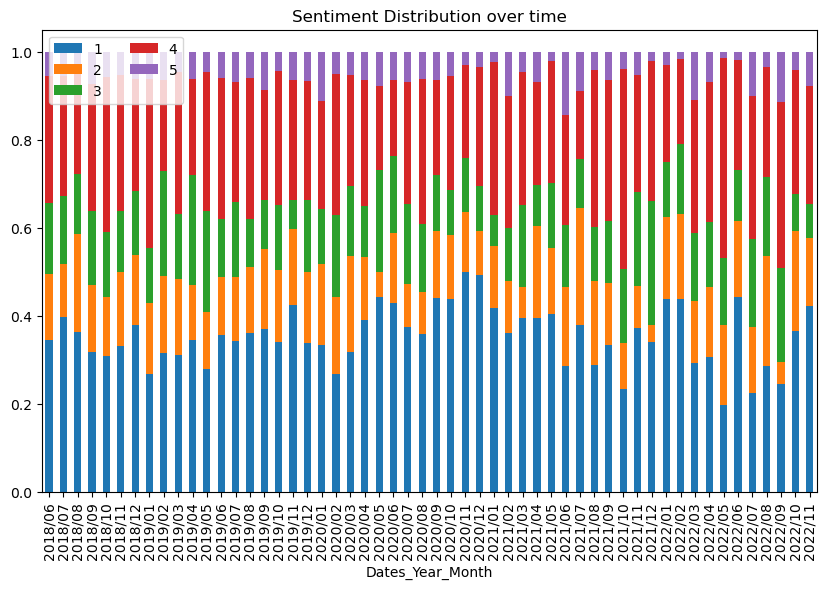

In [69]:
# Plotting Sentiment Distribution over time 
scores_prop.plot(kind='bar', 
                    stacked=True, 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.title('Sentiment Distribution over time')


The stacked bar plot shown that there is no visible trend regarding the sentiment scores of articles adressing refugees over time.

### Topic modeling for different sentiments

In [29]:
# Importing packages for topic modeling 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import spacy 
#!pip install wordcloud
import wordcloud
from wordcloud import WordCloud

In [48]:
# Transform all to lowercase 

Text = articles_df['Text']

Text = [x.lower() for x in Text]

In [53]:
# Lemmatization and stopwords removal for all documents 
lemma_list = []
for doc in nlp.pipe(Text):
    token_pos = []
    for token in doc:
        if token.is_stop == False:
            token_pos.append(
                    token.lemma_
            )
    lemma_list.append(token_pos)


In [56]:
# Recombine tokenized documents to coherent text in order to use it in the CountVectorizer (next step)
lematized_text = []
for l in lemma_list:
    text = ' '.join(l)
    lematized_text.append(text)
    
articles_df['lem_text'] = lematized_text

In [57]:
#split dataframe into positive and negative Sentiments
articles_df_pos = articles_df.loc[articles_df['Scores'].isin([4, 5])]
articles_df_neg = articles_df.loc[articles_df['Scores'].isin([1, 2])]

In [70]:
# Define German stopwords library 

german_stop_words = stopwords.words('german')
vectorizer = TfidfVectorizer(stop_words = german_stop_words)

In [67]:
# Get the wordcloud for aticles with positive sentiment
vecs = vectorizer.fit_transform(articles_df_pos['lem_text'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
Cloud_pos = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))


In [68]:
# Get the wordcloud for aticles with negative sentiment
vecs = vectorizer.fit_transform(articles_df_neg['lem_text'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
Cloud_neg = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))

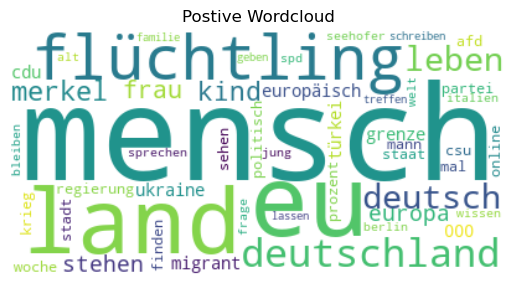

In [71]:
plt.imshow(Cloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Postive Wordcloud')
plt.show()

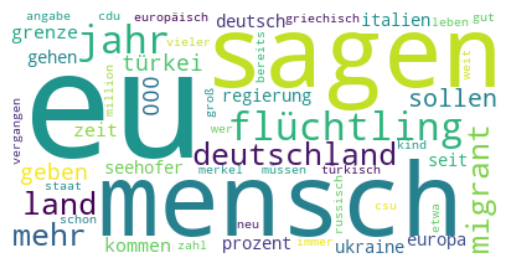

In [34]:
plt.imshow(Cloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Negative WOrdcloud')
plt.show()

Interesting is that the term migrant seems to play a much more important role in the articles with a general negative sentiment. This might be in line with former studies that have shown the importance of certain labels differentiating between “good refugees” and “bad migrants” (Wyszynski et al. 2020). Another aspect is the higher importance of the former chancelor "Merkel" for the articles with a positive sentiment which might indicate a general alliance of the newspaper with her politics.

### References 

Backfried, G., & Shalunts, G. (2016, October). Sentiment analysis of media in german on the refugee crisis in europe. In International Conference on Information Systems for Crisis Response and Management in Mediterranean Countries (pp. 234-241). Springer, Cham. \
Kedia, A., & Rasu, M. (2020). Hands-on Python natural language processing: explore tools and techniques to analyze and process text with a view to building real-world NLP applications. Packt Publishing Ltd.\
Kotelnikova, A., Paschenko, D., Bochenina, K., & Kotelnikov, E. (2022). Lexicon-based methods vs. BERT for text sentiment analysis. In International Conference on Analysis of Images, Social Networks and Texts (pp. 71-83). Springer, Cham.\
Moore, K., Berry, M., & Garcia-Blanco, I. (2018). Saving refugees or policing the seas? How the national press of five EU member states framed news coverage of the migration crisis. Justice, Power and Resistance, 2(1), 66-95.\
Wyszynski, M. C., Guerra, R., & Bierwiaczonek, K. (2020). Good refugees, bad migrants? Intergroup helping orientations toward refugees, migrants, and economic migrants in Germany. Journal of Applied Social Psychology, 50(10), 607-618.
